In [23]:
data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
!wget $data -O course_lead_scoring.csv

--2025-12-24 16:30:59--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.02s   

2025-12-24 16:31:00 (4.12 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



In [24]:
import pandas as pd
import numpy as np

df = pd.read_csv("course_lead_scoring.csv")

# 1

In [25]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = [col for col in df.columns if col not in categorical and col != 'converted']

df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0)

In [26]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
print(len(df_full_train), len(df_test))

1169 293


In [27]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
print(len(df_train), len(df_val))

876 293


In [28]:
df_full_train = df_full_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_full_train = df_full_train.converted.values
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_full_train['converted']
del df_train['converted']
del df_val['converted']
del df_test['converted']

In [29]:
from sklearn.metrics import roc_auc_score

for col in numerical:
    score = roc_auc_score(y_train, df_train[col])
    if score < 0.5:
        score = 1 - score
    print('Column %s: %.4f' % (col, score))



Column number_of_courses_viewed: 0.7636
Column annual_income: 0.5520
Column interaction_count: 0.7383
Column lead_score: 0.6145


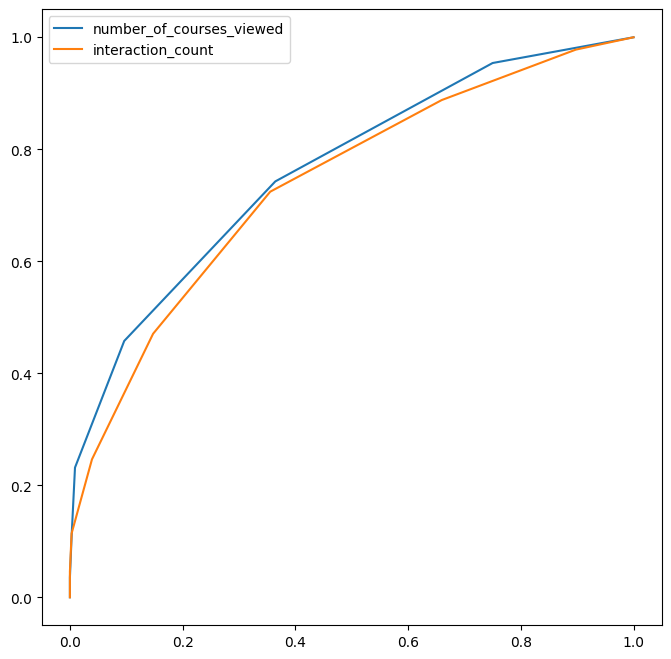

In [30]:
# now we plot it

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

plt.figure(figsize=(8, 8))

fpr, tpr, _ = roc_curve(y_train, df_train['number_of_courses_viewed'])
plt.plot(fpr, tpr, label='number_of_courses_viewed')

fpr, tpr, _ = roc_curve(y_train, df_train['interaction_count'])
plt.plot(fpr, tpr, label='interaction_count')
plt.legend()
plt.show()

# 2

In [46]:
def train(df, y_train, C=1.0):
    from sklearn.linear_model import LogisticRegression
    from sklearn.feature_extraction import DictVectorizer

    dv = DictVectorizer(sparse=False)

    train_dicts = df[categorical + numerical].to_dict(orient='records')
    X_train = dv.fit_transform(train_dicts)

    model = LogisticRegression(solver='lbfgs', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    from sklearn.feature_extraction import DictVectorizer

    dicts = df[categorical + numerical].to_dict(orient='records')
    X_val = dv.transform(dicts)

    y_pred = model.predict_proba(X_val)[:, 1]

    return y_pred

In [47]:
dv, model = train(df_train, y_train, C=1.0)
y_pred = predict(df_val, dv, model)
auc = roc_auc_score(y_val, y_pred)
print('AUC = %.3f' % auc)

AUC = 0.919


/home/teo/workspace/machine-learning-zoomcamp-homework/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Note: the question requires liblinear but the default used by the example solution is actually `lbfgs`. Using liblinear yields a "wrong" result for the quiz.

# 3

In [48]:
thresholds = np.linspace(0, 1, 101)
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [51]:
precisions = []
recalls = []
f1s = []

for threshold in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predicted_positive = (y_pred >= threshold)
    predicted_negative = (y_pred < threshold)

    tp = (predicted_positive & actual_positive).sum()
    tn = (predicted_negative & actual_negative).sum()
    fp = (predicted_positive & actual_negative).sum()
    fn = (predicted_negative & actual_positive).sum()

    precision = tp/ (tp + fp)
    recall = tp / (tp + fn)

    f1 = 2 * precision * recall / (precision + recall)

    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

/tmp/ipykernel_667498/1763616825.py:17: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/ (tp + fp)


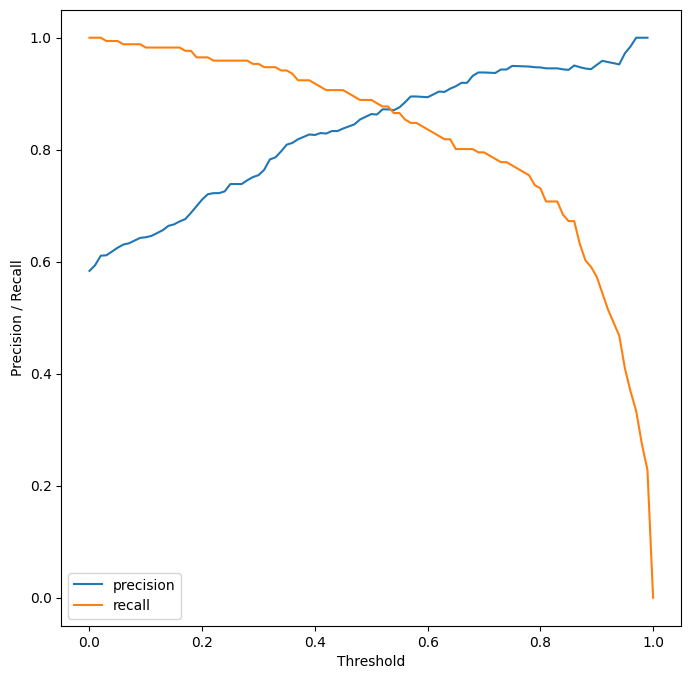

In [50]:
# now we plot precision and recall vs threshold

plt.figure(figsize=(8, 8))
plt.plot(thresholds, precisions, label='precision')
plt.plot(thresholds, recalls, label='recall')
plt.xlabel('Threshold')
plt.ylabel('Precision / Recall')
plt.legend()
plt.show()

# 4

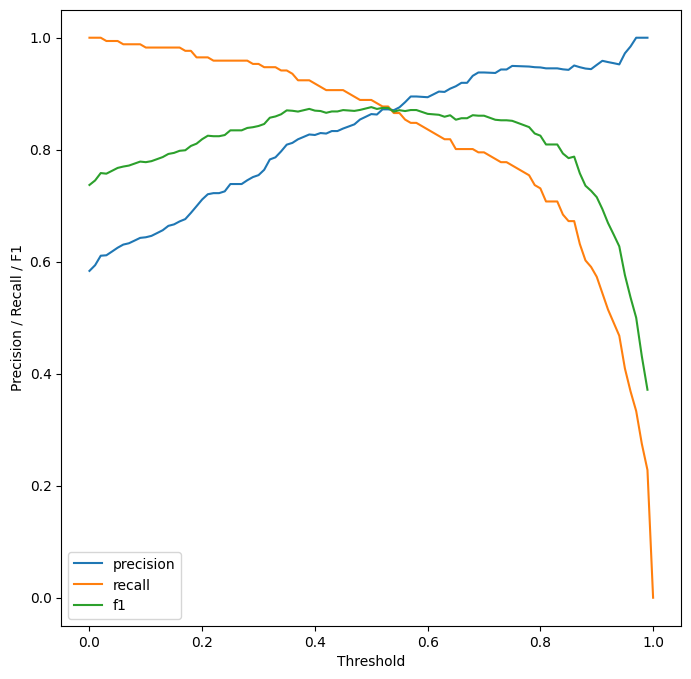

In [52]:
# now we plot precision, recall and f1 vs threshold

plt.figure(figsize=(8, 8))
plt.plot(thresholds, precisions, label='precision')
plt.plot(thresholds, recalls, label='recall')
plt.plot(thresholds, f1s, label='f1')
plt.xlabel('Threshold')
plt.ylabel('Precision / Recall / F1')
plt.legend()
plt.show()

# 5

In [55]:
def train(df, y_train, C=1.0):
    from sklearn.linear_model import LogisticRegression
    from sklearn.feature_extraction import DictVectorizer

    dv = DictVectorizer(sparse=False)

    train_dicts = df[categorical + numerical].to_dict(orient='records')
    X_train = dv.fit_transform(train_dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    from sklearn.feature_extraction import DictVectorizer

    dicts = df[categorical + numerical].to_dict(orient='records')
    X_val = dv.transform(dicts)

    y_pred = model.predict_proba(X_val)[:, 1]

    return y_pred

In [56]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = y_full_train[train_idx]
    y_val = y_full_train[val_idx]

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)
    auc = roc_auc_score(y_val, y_pred)
    print('AUC = %.3f' % auc)

    scores.append(auc)

print('Mean AUC = %.3f Stdev = %.3f' % (np.mean(scores), np.std(scores)))

AUC = 0.806
AUC = 0.871
AUC = 0.775
AUC = 0.802
AUC = 0.856
Mean AUC = 0.822 Stdev = 0.036


# 6

In [57]:

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.000001, 0.001, 1]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = y_full_train[train_idx]
        y_val = y_full_train[val_idx]

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        auc = roc_auc_score(y_val, y_pred)
        print('AUC = %.3f' % auc)

        scores.append(auc)

    print('C = %.6f Mean AUC = %.3f Stdev = %.3f' % (C, np.mean(scores), np.std(scores)))

AUC = 0.557
AUC = 0.519
AUC = 0.589
AUC = 0.558
AUC = 0.577
C = 0.000001 Mean AUC = 0.560 Stdev = 0.024
AUC = 0.861
AUC = 0.897
AUC = 0.823
AUC = 0.854
AUC = 0.900
C = 0.001000 Mean AUC = 0.867 Stdev = 0.029
AUC = 0.806
AUC = 0.871
AUC = 0.775
AUC = 0.802
AUC = 0.856
C = 1.000000 Mean AUC = 0.822 Stdev = 0.036
